# Crystal growth

If the temperature, pressure or composition changes so will the equilibrium solid volume.
Assuming phase equilibrium would mean that this change in volume was instantaneous but
if the crystal growth (or dissolution) rate is, in fact, limited. This can make it possible
to depart from phase equilibrium. This notebook outlines our approach to calculating the
crystal growth rate in the F-layer.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import growth
import feo_thermodynamics

## Crystal growth following Sun et al. (2018)

Here we follow Sun et al. (2018; Nature Materials 17:881-886, https://doi.org/10.1038/s41563-018-0174-6)
who simulate crystal growth of the FCC metals Al, Ni, Cu, Ag, Pt and Pb using an embedded atom model at
temperatures from the (simulated) melting point down to undercoolings of ~300 K below the melting point in order
to understand why crystal growth for these crystals was "ultrafast". These calculations were undertaken
using LAMMPS and were not at elevated pressure. These atomic scale results were compared with three models
and an empirical fit:

1. A linear fit of growth rate against undercooling
2. The Wilson–Frenkel model, where growth is limited by diffusion in the liquid
3. A Ginzburg–Landau approach, where growth is controlled by density fluctuations in the liquid
4. A collision rate model

All these models can be described the interaction of a kinetic and a thermodynamic term (equation 1 of Sun; S1):

$$ V(T) = k(T) \left[1 - \exp\left(\frac{\Delta\mu}{k_B T}\right)  \right],$$

where $V(T)$ is the growth rate of the crystal (normal to the 111 face) $k(T)$ is a kinetic function and
$\Delta\mu$ is the difference in the chemical potential of the solid and the liquid. 
$k(T)$ is different for the different models:

1. $k(T) = k_0$
2. $k(T) = l\frac{6D(T)}{\gamma^2}$
3. $k(T) \propto \frac{S(K_i)}{\tau(K_i)}$
3. $k(T) \propto \sqrt{\frac{3K_B T}{M}}$

Models 1 and 4 reproduce the atomic scale data fairly well over the temperature range (see Sun et al. Fig 1).

For simplicity, we assume model 1 and write a growth rate function.

The next cells show how to calculate the growth rate for model 1 for copper.

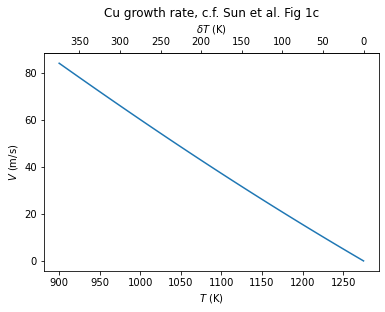

In [2]:
# Calculate growth velocity of Cu as a function of temperatue to compare with Sun et al.

# Properties of copper
kb = 1.380648e-23 # Boltzmann constant
cu_k0 = 212.0 # [K^-1] Table 2
cu_tm = 1275.0 # [K] Table 1
cu_dhm = 1.21 * kb * cu_tm # [J] SI table S1, heat of fusion at melting point

# Calculate growth rate using functions from growth module
ts = np.linspace(900, cu_tm) # Absolute temperature
dts = cu_tm - ts # Undercoolling
d_mu = growth.sun_d_mu(dts, cu_tm, cu_dhm) # Difference in chemical potentials
vs  = growth.growth_velocity_sun(d_mu, cu_k0, ts)

# Plot graph - like Fig 1 of paper
fig, ax = plt.subplots()
ax.plot(ts, vs)
ax.set_xlabel('$T$ (K)')
ax.set_ylabel('$V$ (m/s)')
secax = ax.secondary_xaxis('top', functions=(lambda dt: cu_tm - dt,lambda t: cu_tm - t))
secax.set_xlabel('$\delta T$ (K)')
ax.set_title('Cu growth rate, c.f. Sun et al. Fig 1c')
plt.show()

## Fe-O mixture

There are two interesting implications of an Fe-O mixture. First, the chemical potential
difference for Fe in the liquid and the solid will depend on the amount of O in the 
liquid (at least if we follow the Komabayashi model) and this will stop growth 
(because as the chemical potential difference tends to zero) as the
solid fraction approaches equilibrium. Second, we don't really have any information
about the model to use (or the parameters to pick). We'll assume that we can use the
simple model and make $k_0$ a free parameter. 

From the Komabayashi thermodynamic model we can calculate $\Delta\mu_{Fe}$ for any combination of Fe concentration in the liquid, temperature and pressure. As we'll only consider crystallization
of solid Fe (not FeO), $\Delta\mu_{Fe} = \mu_{Fe}^{solid}(P,T) - \mu_{Fe}^{liquid}(P,T,X)$,
growth rate will be 
positive if the composition and temperature is below and to the Fe side of the liquidus
(crystals will grow) and negative if the composition and temperature are above or to the 
right of the liquidus (crystals will melt). As crystals grow the composition of the liquid
will become enriched in O and growth rate will decrease to zero on the liquidus (when phase
equilibrium is reached). 

In some sense $k(T)$ captures limitations to growth on the crystal surface (e.g. island
nucleation) and limitations on removal of O from the interface (diffusion). It is not
totally clear how to treat these effects, especially given that our particle moves,
so we'll treat the diffusion part separately and assume model 1 from above
(taking $k_0$ as a parameter that relates to the pure Fe surface in some way). 

The next cells show how to calculate growth rate as a function of solid volume fraction
in an FeO melt. We'll assume a fixed box volume with fixed oxygen content, temperature 
and pressure, vary the amount of solid and calculate the growth rate (as ever, assuming
all the oxygen is in the solid). What we should see is that the growth rate is negative
if the solid fraction is above that predicted by equilibrium thermodynamics and positive
if it is below that predicted by equilibrium thermodynamics. For the way this is set up
we need to do the calculation in two steps: first evaluate the oxygen content of the 
liquid from the volume fraction, then use this to evaluate the chemical potential and
growth rate. Helper functions in the next cell impose this conservation of oxygen.


In [3]:
# Helper functions Volume fraction solid to mol frac

def volume_fraction_solid(mol_fraction_solid, x_l, p, t):
    """
    Return the volume fraction solid given the mole fraction solid and state
    
    We need to know the temperature, pressure and liquid composition as these
    set the volume of a mole of the solid and the liquid (i.e. the densities)
    """
    mol_vol_liquid, _, _ = feo_thermodynamics.liquid_molar_volume(x_l, p, t)
    _, mol_vol_solid, _ = feo_thermodynamics.solid_molar_volume(1.0, p, t)
    vf_solid = (mol_frac_solid * mol_vol_solid) / (mol_frac_solid * mol_vol_solid + 
                                            (1.0 - mol_frac_solid) * mol_vol_liquid)
    return vf_solid

def mol_fraction_solid(volume_fraction, x_l, p, t):
    """
    Return the mole fraction solid given the volume fraction solid and state
    
    We need to know the temperature, pressure and liquid composition as these
    set the volume of a mole of the solid and the liquid (i.e. the densities)
    """
    mol_vol_liquid, _, _ = feo_thermodynamics.liquid_molar_volume(x_l, p, t)
    _, mol_vol_solid, _ = feo_thermodynamics.solid_molar_volume(1.0, p, t)
    mol_solid = volume_fraction / mol_vol_solid
    mol_liquid = (1.0 - volume_fraction) / mol_vol_liquid
    mol_frac_solid = mol_solid / (mol_solid + mol_liquid) 
    return mol_frac_solid

/Users/andreww/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/lib/function_base.py:2197: RuntimeWarning: invalid value encountered in phase_relations_molar (vectorized)
  outputs = ufunc(*inputs)


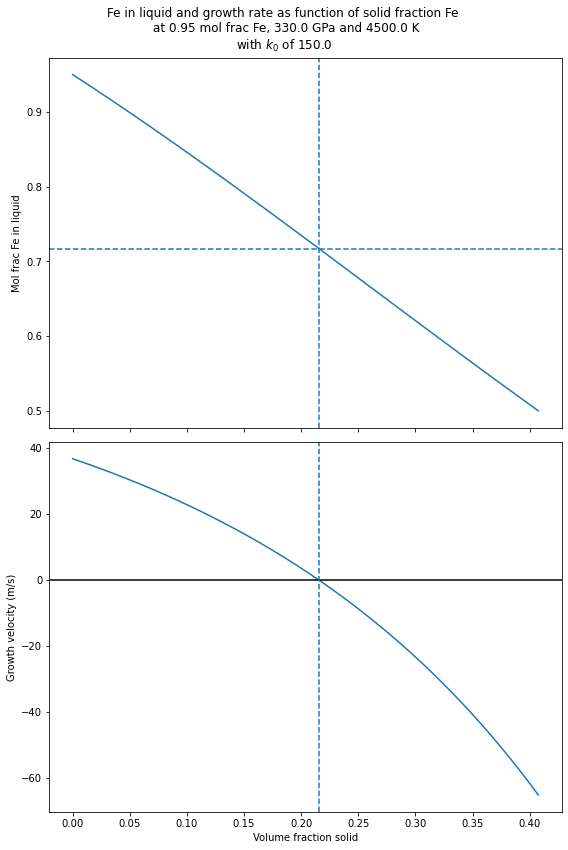

In [4]:
# Pick a point fairly deep inside the two phase region.
t = 4500.0 # K
x = 0.95 # mol frac Fe in total
p = 330.0 # GPa
k0 = 150.0 # m/s

# Setup liquid contents and volume fractions solid
# (conserve O). It is *much* easer if we go from the
# molar fraction Fe in the liquid (and total Fe mol fraction)
# to volume fraction solid than the other way around (as the)
# total volume depends on the composition of the liquid.

x_l = np.linspace(0.5, x) # Don't go too far towards FeO, we don't want solid FeO to be stable
mol_frac_solid = 1.0 - (x_l/x)
vf_solid = volume_fraction_solid(mol_fraction_solid, x_l, p, t)


# For plotting only - what is equilibrium?
# This comes from the thermodynamic model looking
# at the energetics.
x_lq_eq, _, _, _, _ = \
        feo_thermodynamics.phase_relations_molar(x, p, t)
mol_frac_solid = 1.0 - (x_lq_eq/x)
vf_solid_eq = volume_fraction_solid(mol_frac_solid, x_lq_eq, p, t)

# Plot volume fraction
fig, axs = plt.subplots(nrows=2, figsize=(8,12), sharex=True)
fig.suptitle(f"Fe in liquid and growth rate as function of solid fraction Fe \n at {x} mol frac Fe, {p} GPa and {t} K\nwith $k_0$ of {k0}")
ax = axs[0]
ax.plot(vf_solid, x_l)
ax.axhline(x_lq_eq, ls='--')
ax.axvline(vf_solid_eq, ls='--')
ax.set_ylabel('Mol frac Fe in liquid')

# Calculate the growth velocity - assume liquid is always well mixed (oxygen content in
# contact with solid is the same as the bulk oxygen content). This function makes use
# of the thermodynamic model.
v = growth.growth_velocity_feo(x_l, p, t, k0)

ax = axs[1]

ax.plot(vf_solid, v)
ax.axhline(0, c='k', ls='-')
ax.axvline(vf_solid_eq, ls='--')
ax.set_xlabel('Volume fraction solid')
ax.set_ylabel('Growth velocity (m/s)')

plt.tight_layout()
plt.show()

## Crystals(s) growing in a box

With this in hand, we can do a calculation of growth rate as the crystal volume changes
with time. 
For this example we consider a box of Fe-FeO melt with a fixed overall composition, pressure and 
temperature starting with some number of seed crystals with (equal) radii. We timestep the system
and track the composition of the melt and size of the crystals as they grow or dissolve and the
system approached (phase) equilibrium. We assume that the melt is always well mixed (there is no
chemical boundary layer around the growing crystals).

/Users/andreww/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/lib/function_base.py:2197: RuntimeWarning: invalid value encountered in phase_relations_molar (vectorized)
  outputs = ufunc(*inputs)


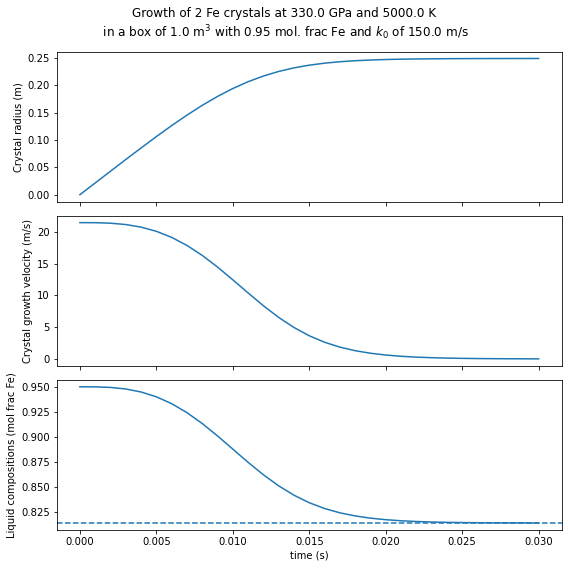

In [5]:
r0 = 1.0E-10 # initial radius, m
n = 2 # number of crystals
t = 5000.0 # temperature, K
p = 330.0 # GPa
x = 0.95 # Overall composition, mol frac Fe
k0 = 150.0 # growth rate prefactor, m/s
box_size = 1.0 # initial volume of the box (m^3)
time_step = 0.001 # s
total_time = 0.03 # s

x_lq_eq, _, _, _, _ = \
        feo_thermodynamics.phase_relations_molar(x, p, t)

rs = [] # List to store radii
ts = [] # List to store times
vs = [] # List of growth velocites
x_ls = [] # List of liquid compositions

time = 0.0
r = r0
solid_volume = (4.0/3.0) * np.pi * r**3 * n
vf_solid = solid_volume / box_size
# assume x is liquid composition here ... particles are small at t0 but can we fix?
mf_solid = mol_fraction_solid(vf_solid, x, p, t)
x_l = x * (1.0 - mf_solid) # Is this correct?
v = growth.growth_velocity_feo(x_l, p, t, k0)
rs.append(r)
ts.append(time)
vs.append(v)
x_ls.append(x_l)

# Forward Euler to calculate particle size as function of time.
while time < total_time:
    # grow particles
    r = r + v*time_step
    solid_volume = (4.0/3.0) * np.pi * r**3 * n
    vf_solid = solid_volume / box_size # Box size should have changed...
    mf_solid = mol_fraction_solid(vf_solid, x_l, p, t)
    x_l = x * (1.0-mf_solid) # Is this correct?
    ## x_l_2 = (x + mf_solid) / (1 - mf_solid)
    ## print(x_l, x_l_2)
    v = growth.growth_velocity_feo(x_l, p, t, k0)
    time = time + time_step
    rs.append(r)
    ts.append(time)
    vs.append(v)
    x_ls.append(x_l)

    
fig, axs = plt.subplots(nrows=3, figsize=(8,8), sharex=True)

fig.suptitle(f"Growth of {n} Fe crystals at {p} GPa and {t} K\n in a box of {box_size} m$^3$ with {x} mol. frac Fe and $k_0$ of {k0} m/s")

ax = axs[0]
ax.plot(ts, rs)
ax.set_ylabel('Crystal radius (m)')

ax=axs[1]
ax.plot(ts, vs)
ax.set_ylabel('Crystal growth velocity (m/s)')

ax=axs[2]
ax.plot(ts, x_ls)
ax.set_xlabel('time (s)')
ax.set_ylabel('Liquid compositions (mol frac Fe)')
ax.axhline(x_lq_eq, ls='--')

plt.tight_layout()
plt.show()

## Boundary layer

This model mirrors the setup above but we allow a compositional boundary layer to form around the particle.
The boundary layer forms because there is a flux of oxygen out of the particle as it grows, locally
enriching the oxygen content (decreasing $x$). The increase in oxygen content as the particle grows
is balanced by diffusion away from the boundary (in the liquid) and, following a derivation in the
overleaf document, the relationship between crystal growth rate and oxygen flux at the interface is
given by:

$$\left. \frac{\partial x}{\partial r}\right|_{r=r_p} = \frac{x_p}{D_l} \frac{\mathrm{d} r_p}{\mathrm{d} t} $$

where $x_p$ is the liquid composition at the particle interface (at $r_p$), $D_l$ is the oxygen diffusion
coefficient, and $t$ is time. $r$ is measured outwards from the center of the particle. The growth rate still also
depends on the liquid composition at the particle interface via the chemical potential change as above.

We assume that the boundary layer structure is linear, increasing from some value at the interface, given by
$x_p = x(r_p)$, to some other value, $x_l = x(r_p + \delta)$, at and beyond the outer edge of the boundary layer (which has a
thickness $\delta_c$):

$$ \left. \frac{\partial x}{\partial r}\right|_{r=r_p} \approx \frac{x_p - x_l}{\delta_c} $$

This allows us to relate the structure of the boundary layer to the growth rate of the
particle:

$$ x_p + \frac{\delta_c x_p}{D_L}  \frac{\mathrm{d} r_p}{\mathrm{d} t} - x_l = 0$$

As the growth rate depends on the chemical potential difference at the interface:

$$\frac{\mathrm{d} r_p}{\mathrm{d} t} = k_0 \left[1 - \exp\left(\frac{\Delta\mu(P,T,x_p)}{k_B T}\right)  \right] $$

This means we can find the the value of $x_p$ that gives a growth rate and chemical gradient in the boundary
layer that matches the composition of the bulk liquid outside the boundary layer by performing root finding
with a single unknown ($x_p$). Our solution proceeds as follows (in `growth.diffusion_growth_velocity`):

1. Given $x_l$, $D_L$, $k_0$, $P$ and $T$:
2. Compute $\frac{\mathrm{d} r_p}{\mathrm{d} t}$ from the thermodynamic model
3. Compute $x_[ + \left. \frac{\partial x}{\partial r}\right|_{r=r_p} - x_l$ for this growth
4. If (3) is zero, the solution has converged, if not converged update $x_p$ to reduce the error and go to 2.
5. Once $x_p$ converges to a solution, we have a self-consistent growth rate (and can update the particle radius).

Steps 2-4 are done inside of SciPy's implementation of Brent's root finding algorithm with the boundary
composition limited to 1.0E-16 and 1.0 - 1.0E-16. In the next cell, we use this code to see how growth rate varies 
with boundary layer thickness for different values of $k_0$ and $D_l$ (assuming fixed $P$, $T$, and $x_l$).



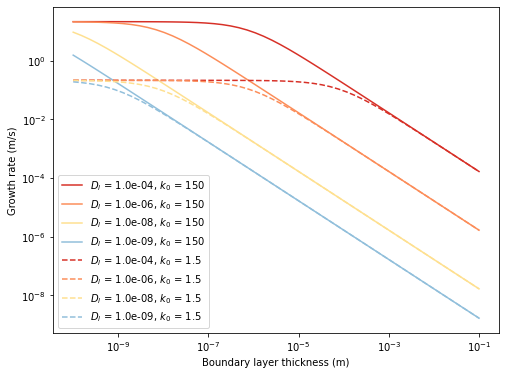

In [6]:
xl = 0.95
t = 5000.0
p = 330.0

deltas = np.logspace(-10, -1) # From the smallest possile (about an atom) to 10 cm...
k0s = [150, 1.5]
linestyles = ['-', '--']
dls = [1.0E-4, 1.0E-6, 1.0E-8, 1.0E-9]
thecolors = ['#d73027', '#fc8d59', '#fee090', '#91bfdb', '#4575b4']
vs = []

fig, ax = plt.subplots(figsize=(8,6))

for j, k0 in enumerate(k0s):
    for i, dl in enumerate(dls):
        for delta in deltas:
            v, xp = growth.diffusion_growth_velocity(xl, delta, p, t, dl, k0)
            vs.append(v)
        ax.plot(deltas, np.array(vs), label=f'$D_l$ = {dl:.1e}, $k_0$ = {k0}', 
                linestyle=linestyles[j], color=thecolors[i])
        vs = []

ax.legend(loc='lower left')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel('Growth rate (m/s)')
ax.set_xlabel('Boundary layer thickness (m)')
plt.show()

## Summary figure

We now generate a summary figure for the manuscript showing how the parameters all influence growth rate.

/Users/andreww/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/lib/function_base.py:2197: RuntimeWarning: invalid value encountered in phase_relations_molar (vectorized)
  outputs = ufunc(*inputs)


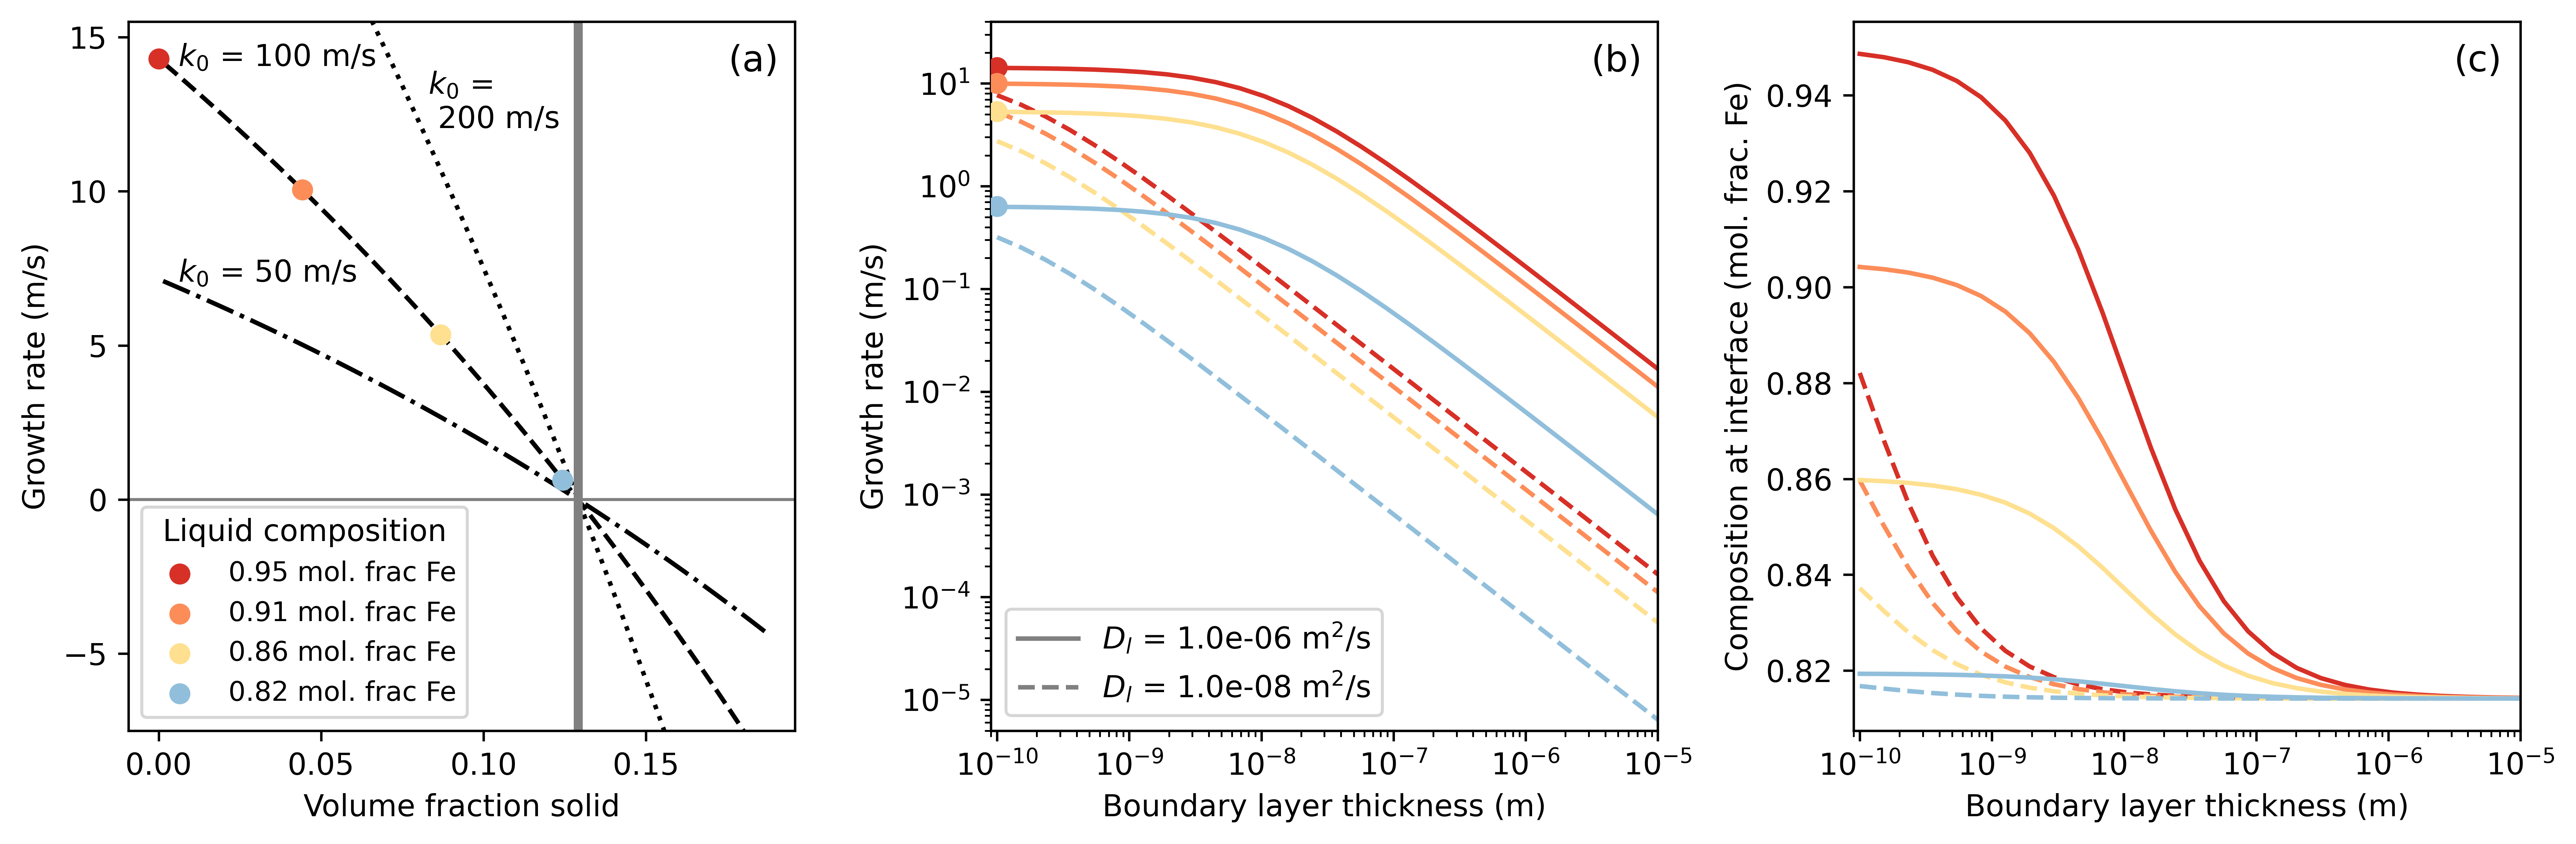

In [7]:
xl = 0.95
t = 5000.0
p = 330.0

deltas = np.logspace(-10, -1) # From the smallest possile (about an atom) to 10 cm...
k0 = 100
k0_slow = 50
k0_fast = 200
linestyles = ['-', '--']
dls = [1.0E-6, 1.0E-8]
thecolors = ['#d73027', '#fc8d59', '#fee090', '#91bfdb', '#4575b4']
vs = []
all_xps = []

# Plotting results. 8" wide and 600 dpi (approx A4, which is what we want)
fig, axs = plt.subplots(ncols=3, figsize=(12,4), dpi=600, tight_layout=True)

# Setup liquid contents and volume fractions solid
# (conserve O). It is *much* easer if we go from the
# molar fraction Fe in the liquid (and total Fe mol fraction)
# to volume fraction solid than the other way around (as the)
# total volume depends on the composition of the liquid.

xl_vary = np.linspace(0.75, xl) # Don't go too far towards FeO, we don't want solid FeO to be stable
mol_frac_solid = 1.0 - (xl_vary/xl)
vf_solid = volume_fraction_solid(mol_fraction_solid, xl_vary, p, t)

# Two points to link graphs
xl_point = np.array([xl_vary[49], xl_vary[38], xl_vary[27], xl_vary[17]])
vf_point = np.array([vf_solid[49], vf_solid[38], vf_solid[27], vf_solid[17]])


# For plotting only - what is equilibrium?
# This comes from the thermodynamic model looking
# at the energetics.
x_lq_eq, _, _, _, _ = \
        feo_thermodynamics.phase_relations_molar(xl, p, t)
mol_frac_solid = 1.0 - (x_lq_eq/xl)
vf_solid_eq = volume_fraction_solid(mol_frac_solid, x_lq_eq, p, t)


ax = axs[0]

# Calculate the growth velocity - assume liquid is always well mixed (oxygen content in
# contact with solid is the same as the bulk oxygen content). This function makes use
# of the thermodynamic model.
v = growth.growth_velocity_feo(xl_vary, p, t, k0)
v_slow = growth.growth_velocity_feo(xl_vary, p, t, k0_slow)
v_fast = growth.growth_velocity_feo(xl_vary, p, t, k0_fast)

v_point = growth.growth_velocity_feo(xl_point, p, t, k0)

ax.plot(vf_solid, v, ls='--', c='k')
ax.plot(vf_solid, v_slow, ls='-.', c='k')
ax.plot(vf_solid, v_fast, ls=':', c='k')

for i in range(vf_point.size):
    ax.scatter(vf_point[i], v_point[i], zorder=100, c=thecolors[i], label=f"{xl_point[i]:.2f} mol. frac Fe")

ax.axhline(0, ls='-', lw=1, c='gray')
ax.axvline(vf_solid_eq, ls='-', c='gray', lw=3)
ax.set_ylim(-7.5, 15.5)
ax.text(0.083, 12.05, "$k_0$ = \n 200 m/s")
ax.text(0.006, 14.05, "$k_0$ = 100 m/s")
ax.text(0.006, 7.05, "$k_0$ = 50 m/s")
ax.set_xlabel('Volume fraction solid')
ax.set_ylabel('Growth rate (m/s)')
ax.legend(loc='lower left', title='Liquid composition', prop={'size': 9})


ax = axs[1]
lines = []
labels = []
for j, xlp in enumerate(xl_point):
    for i, dl in enumerate(dls):
        for delta in deltas:
            v, xp = growth.diffusion_growth_velocity(xlp, delta, p, t, dl, k0)
            vs.append(v)
            all_xps.append(xp)
        axs[2].plot(deltas, all_xps, linestyle=linestyles[i], color=thecolors[j],)
        line, = ax.plot(deltas, np.array(vs), 
                    linestyle=linestyles[i], color=thecolors[j],
                    label=f"$D_l$ = {dl:.1e} m$^2$/s")
        lines.append(line)
        vs = []
        all_xps = []
        
for i in range(vf_point.size):
    ax.scatter(1E-10, v_point[i], zorder=100, c=thecolors[i], label=f"{xl_point[i]:.2f} mol. frac Fe in liquid")
  
# Lines for legend
leglines = []
for i, dl in enumerate(dls):
    line, = ax.plot([1E-9, 1E-10], [1000.0, 1000.0], color='grey', linestyle=linestyles[i], label=f"$D_l$ = {dl:.1e} m$^2$/s")
    leglines.append(line)
    
ax.set_ylim(0.5E-5, 4.0E1)
ax.set_xlim(0.9E-10, 1.0E-5)
ax.legend(handles=leglines, loc='lower left')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel('Growth rate (m/s)')
ax.set_xlabel('Boundary layer thickness (m)')


axs[2].set_xscale('log')
axs[2].set_xlim(0.9E-10, 1.0E-5)
axs[2].set_ylabel('Composition at interface (mol. frac. Fe)')
axs[2].set_xlabel('Boundary layer thickness (m)')

axs[0].annotate("(a)", xy=(0.90, 0.93), xycoords="axes fraction", fontsize='large')
axs[1].annotate("(b)", xy=(0.90, 0.93), xycoords="axes fraction", fontsize='large')
axs[2].annotate("(c)", xy=(0.90, 0.93), xycoords="axes fraction", fontsize='large')


plt.show()
